Programming Language: R 3.6.1 in Jupyter Notebook

R Libraries used:
- reshape2
- ggplot2
- repr 
- NLP
- tm

In [25]:
options(warn=-1)
library(reshape2) # for melt and cast functions
library(ggplot2) # for plotting functions
library(repr) # to resize the plots
library(NLP) # natural language preprocessing
library(tm) # text mining library

# EM for Document Clustering
To make the code easier to understand, we firt derive the Expectation and Maximization steps of the hard-EM algorithm for Document Clustering:





Implementation of the Hard-EM (derived above) and soft-EM for document clustering.

## Helper Function

In [2]:
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back 
#          using the exp func 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

### Initialize model parameters randomly

In [3]:
initial.param <- function(vocab_size, K=4, seed=123456){
  set.seed(seed)
  rho <- matrix(1/K,nrow = K, ncol=1) # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)   # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

### E Step for Document Clustering 

In [4]:
# Input: 
#    gamma:  the matrix of posterior probabilities NxK
#    model: the list of parameters (priors Kx1 and means KxVocabSize)
#    counts: the word-document frequency matrix
#    soft: TRUE if soft EM, FALSE if Hard EM
# Output:
#    gamma:  the matrix of posterior probabilities NxK for the given parameters (if soft = TRUE) 
#    z_star:  the vector Nx1 of hard choosen classes for each document given gamma (if soft = FALSE) 
E.step <- function(gamma, model, counts, soft = TRUE){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  # if it is hard EM, we need to select the K with highest gamma
  if(soft == FALSE){
      z_star = max.col(gamma, 'first') # gets the "argmax" class for each observation   
  }
  # if we are doing Hard-EM, we return "z_star", which are the classes assigned for each n, 
  # if we are doing soft-EM, we return "gamma", which is the matrix with posterior probabilities for each k,n
  if(soft==FALSE){
      return(z_star)
  }else{return(gamma)}
}

### M Step for Document Clustering

In [5]:
# Input: 
#    gamma.z_star (if soft = TRUE) :  the matrix of posterior probabilities NxK for the given parameters 
#    gamma.z_star (if soft = FALSE) :  the vector Nx1 of hard choosen classes for each document given gamma 
#    model: the list of old parameters (class priors Kx1 and class means KxVocabSize)
#    counts: the word-document frequency matrix
#    soft: TRUE if soft EM, FALSE if Hard EM
# Output:
#    model: the list of updated parameters (priors Kx1 and means KxVocabSize)


M.step <- function(gamma.z_star, model, counts, soft = TRUE){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  # to avoid NaN where all elements are zeros when calculating the new  means
  eps = matrix(1e-10, nrow = W, ncol = N)
  
  if(soft== TRUE){ # Soft-EM
      gamma = gamma.z_star
      for (k in 1:K){
          ## recalculate the estimations:
          model$rho[k] <- sum(gamma[,k])/N  # the relative cluster size
          model$mu[k,] <- ((counts%*%gamma[,k])+eps[,k])/sum((counts%*%gamma[,k])+eps[,k]) # new means
    
    }      
  }else{ # Hard-EM
      z_star = gamma.z_star
      for (k in 1:K){
          ## recalculate the estimations:
          ## recalculate the estimations:
          model$rho[k] <- sum(z_star==k)/N  # the relative cluster size          
          model$mu[k,] <- rowSums(counts[,z_star==k]+eps[,z_star==k])/sum(rowSums(counts[,z_star==k]+eps[,z_star==k])) 
          # new means
    }

  }

  # Return the result
  return (model)
}

### The Training Objective Function

In [6]:
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### EM for Document Clustering

In [7]:
EM <- function(counts, K=4, max.epoch=10, seed=123456, soft = TRUE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma_kmax <- E.step(gamma, model, counts, soft = soft)
    # M Step
    model <- M.step(gamma_kmax, model, counts, soft = soft)
   
    print(train_obj(model, counts)) 
  }
  # Return Model
  if(soft==TRUE){
      return(list("model"=model,"gamma"=gamma_kmax))}else{
      return(list("model"=model,"k_max"=gamma_kmax))
  }
}

### Read and Pre-process Data

In [28]:
# reading the data
read.data <- function(file.name='./bbc-text.csv', spr.ratio=0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text_df <- read.csv(file.name, colClasses = c('factor', 'character'))
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' 
  ##are the actual documents
  docs <- text_df
  colnames(docs) <- c("doc_id", "text")
  docs$doc_id <- rownames(docs)
  # store the labels for evaluation
  labels <-  text_df$category
    
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words 
    #(the most common word in a language that can be find in any document)
  corp <- tm_map(corp, removePunctuation) # remove pnctuation
  corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
  corp <- tm_map(corp, removeNumbers) # remove all numbers
  corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}
# Reading documents 
## Note: sample.size=0 means all read all documents!
data <- read.data(file.name='./bbc-text.csv', spr.ratio= .99)
# word-document frequency matrix 
counts <- data$word.doc.mat

In [30]:
head(counts)

,1,2,3,4,5,6,7,8,9,10,...,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225
accord,1,0,0,0,1,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
adam,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advert,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advertis,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
allow,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
alreadi,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#  run soft-EM algorithm on the provided data
res_soft <- EM(counts, K=5, max.epoch=10, seed = 200)  
# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat.soft <- apply(res_soft$gamma, 1, which.max)

[1] 3049919
[1] 2713476
[1] 2667142
[1] 2645417
[1] 2635238
[1] 2628601
[1] 2624423
[1] 2622443
[1] 2621742
[1] 2621387
[1] 2621310


In [32]:
#  run soft-EM algorithm on the provided data
res_hard <- EM(counts, K=4, max.epoch=10, soft = FALSE, seed = 200)  
# visualization
## find the choosen cluster (since we have hard assignment here)
label.hat.hard <- res_hard$k_max

[1] 3053548
[1] 2720130
[1] 2686664
[1] 2670998
[1] 2657195
[1] 2651093
[1] 2649465
[1] 2648918
[1] 2648824
[1] 2648763
[1] 2648748


# Visualizing Clusters With PCA

In [33]:
## normalize the count matrix for better visualization
counts<-scale(counts)
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

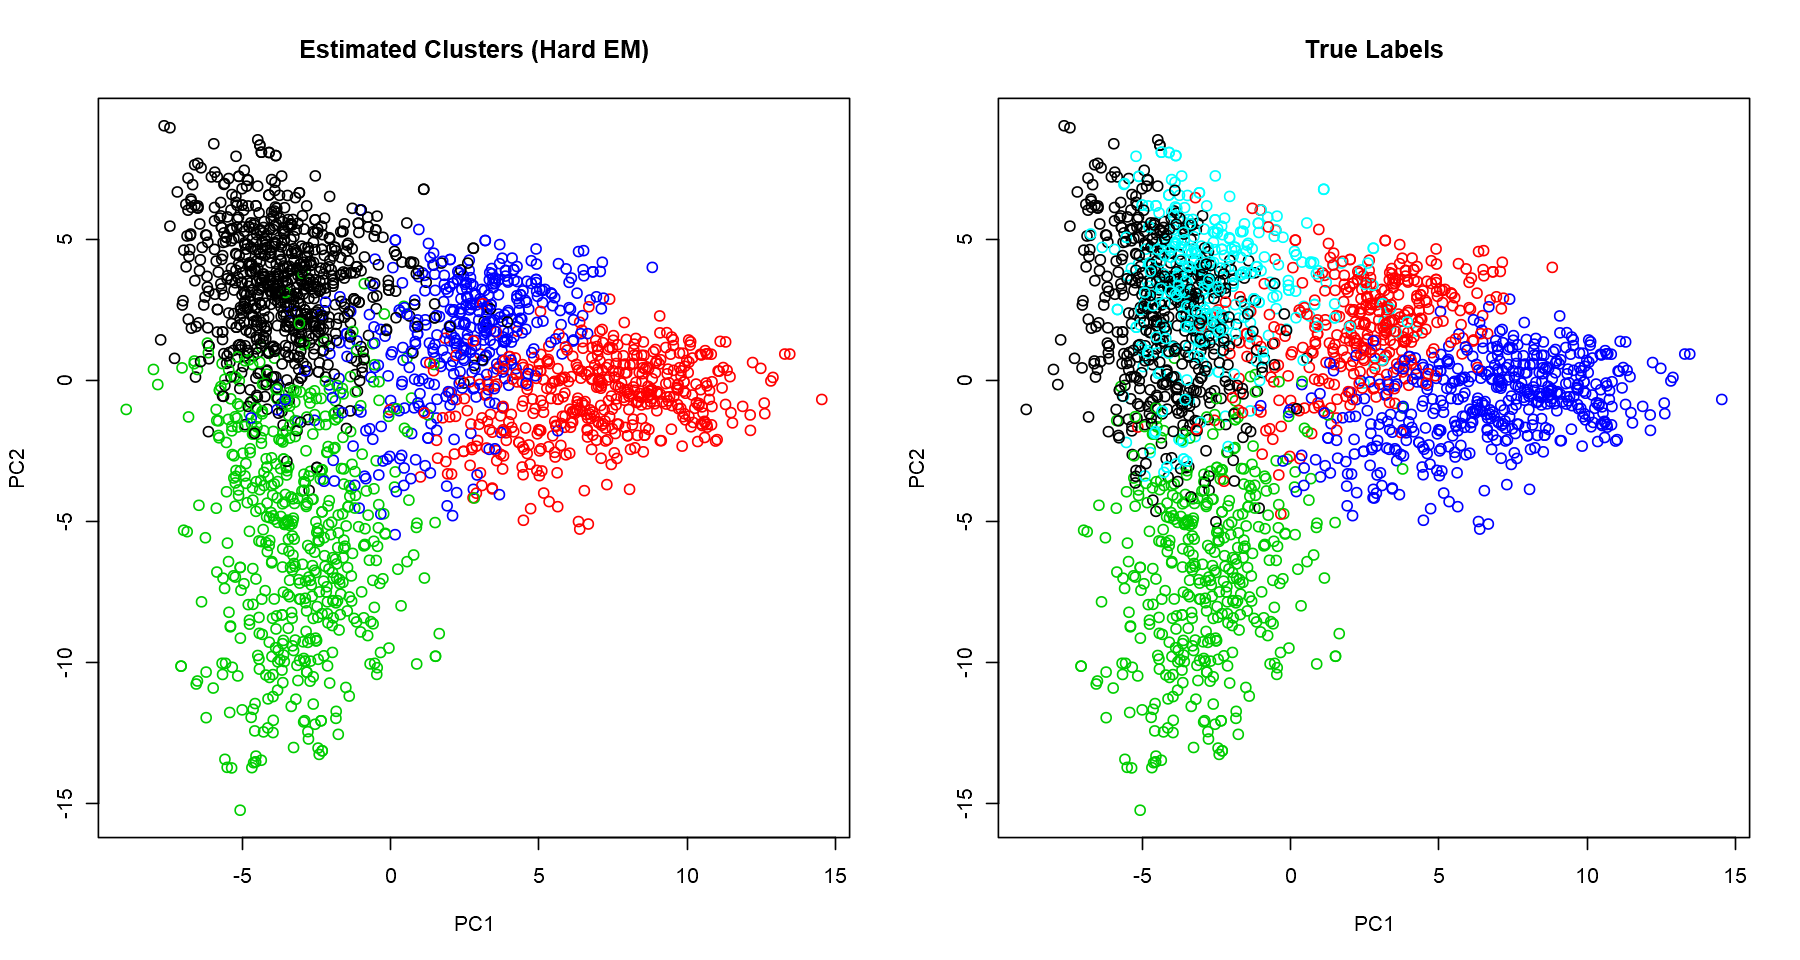

In [37]:
options(repr.plot.width=15, repr.plot.height=8)
par(mfrow=c(1,2))
## visualize the stimated clusters
counts <- scale(counts)
cluster.viz(t(counts), label.hat.hard, 'Estimated Clusters (Hard EM)')
cluster.viz(t(counts), data$labels, 'True Labels')

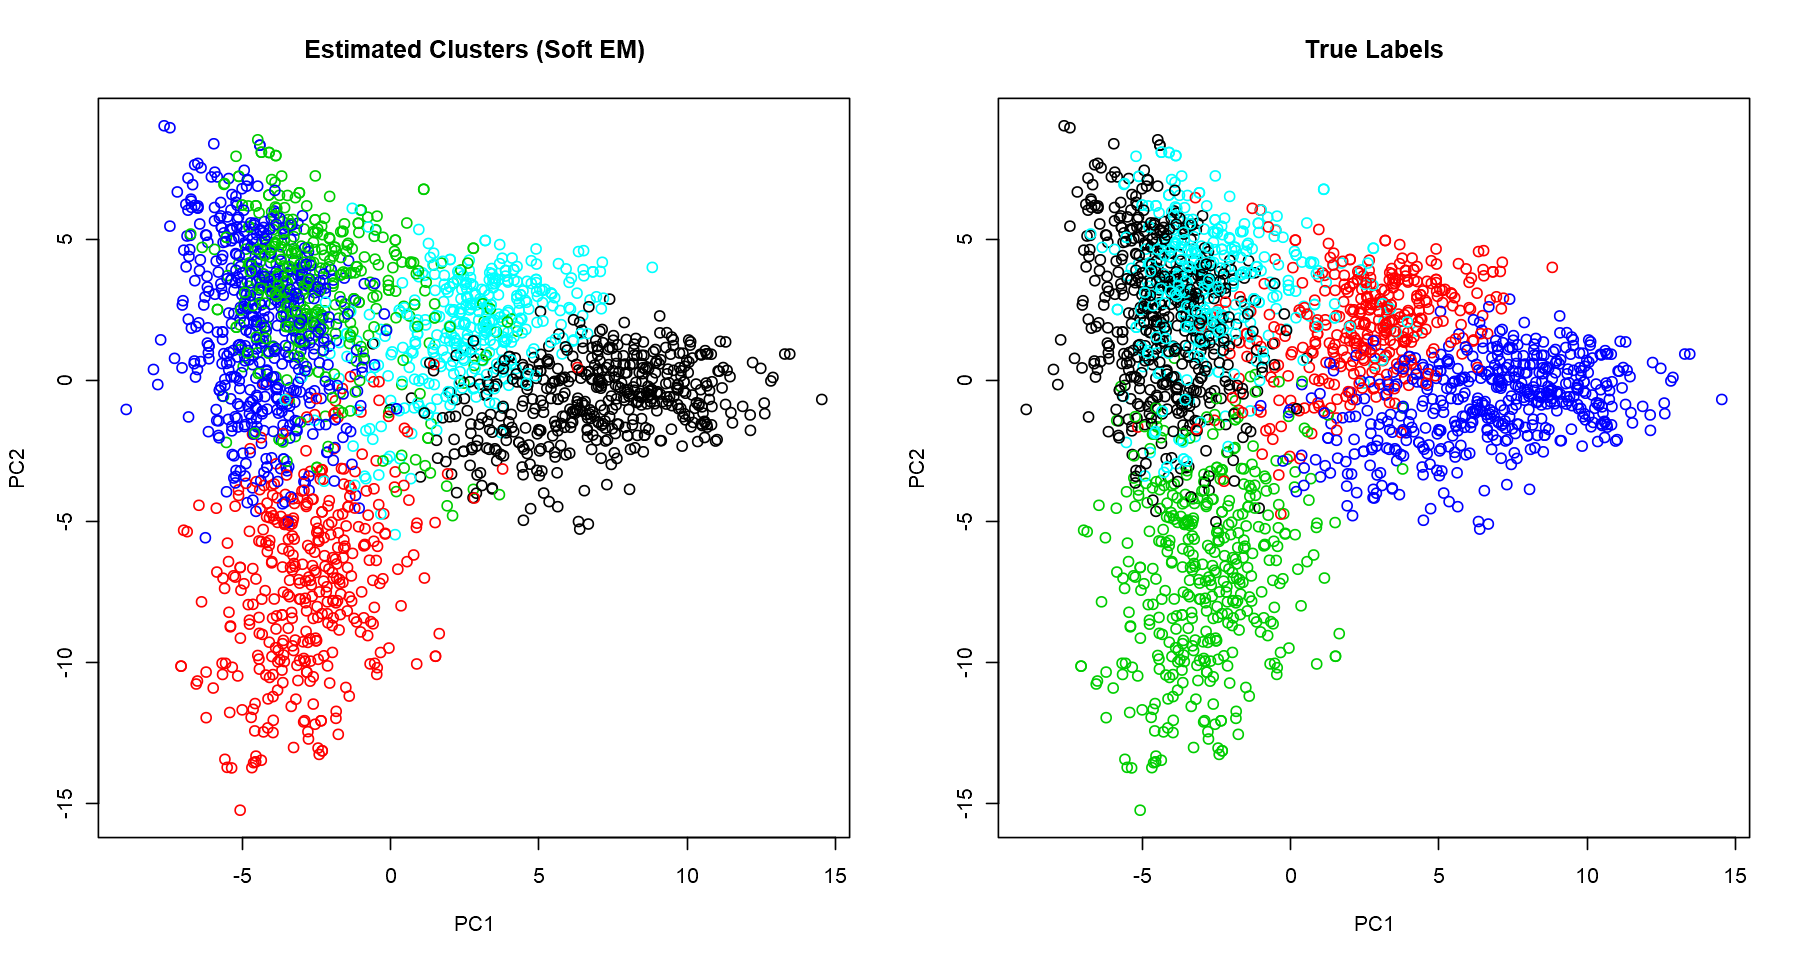

In [36]:
options(repr.plot.width=15, repr.plot.height=8)
par(mfrow=c(1,2))
## visualize the stimated clusters
counts <- scale(counts)
cluster.viz(t(counts), label.hat.soft, 'Estimated Clusters (Soft EM)')
cluster.viz(t(counts), data$labels, 'True Labels')

<font color='darkblue'>**The clusters are very similar but not exactly the same. The algorithm behind both hard and soft EM follows the same steps, with the following differences:**</font>

   <font color='darkblue'>**- Over the Expectation Step, the Soft Algorithm gives us a partial assignment of a datapoint to a cluster based on our probabilistic model. On the other hand, the Hard Algorithm takes those probabilities to assign each datapoint to a unique cluster.**</font>
    
   <font color='darkblue'>**- During the Maximixation Step, the relative cluster size and means are calculated based on either probabilities or hard values (soft X hard EM).**</font>
    
   <font color='darkblue'>**When determining a cluster for the soft EM, the process is the same as in the E-step of the hard EM. We take the final matrix of posterior probabilities and assign each datapoint to the cluster it has higher chances of belonging to according to the model. We can expect both techniques to produce similar results, but not the same as they diverge a bit in each iteration, specially in the way the parameters are updated. When there is a lot of overlapping between to clusters, the differences might be bigger.**</font>